In [165]:
import geopandas as gpd
from shapely.geometry import Point
import psycopg2
from shapely.ops import polygonize
import fiona
import matplotlib.pyplot as plt
import shapely
import numpy as np
import pandas as pd

In [177]:
import pydp as dp
from pydp.algorithms.laplacian import BoundedMean

In [2]:
def db_conn():
    
    conn = psycopg2.connect(
        host="34.159.36.105",
        port ="5432",
        database="geodp",
        user="postgres", 
        password='postgres')
    cur = conn.cursor()

    return cur, conn

In [3]:
def f():
    cursor, conn = db_conn()
    cursor.execute("SELECT st_x(geom), st_y(geom) FROM smalldata;")
    rows = cursor.fetchall()
    cursor.close()

    result = []
    for index in range(len(rows)):
        result.append([
            rows[index][0],
            rows[index][1]
            
        ])

    return result

In [4]:
l = f()
x = []
y = []

In [5]:
for i in l:
    x.append(i[0])
    y.append(i[1])

In [6]:

points = gpd.GeoDataFrame({"x":x,"y":y})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)
print(points.head(2))

            x          y                     geometry
0 -117.761091  33.702979  POINT (-117.76109 33.70298)
1 -118.217049  34.358922  POINT (-118.21705 34.35892)


In [ ]:
hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(x[:-1], x[1:]) for yi in y]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(y[:-1], y[1:]) for xi in x]

grids = list(polygonize(MultiLineString(hlines + vlines)))

In [7]:
hlines = [((x1, yi), (x2, yi)) for x1, x2 in list(zip(gridx[:-1], gridx[1:])) for yi in gridy]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(gridy[:-1], gridy[1:]) for xi in gridx]
polys = list(polygonize(MultiLineString(hlines + vlines)))
id = [i for i in range(len(grids))]
grid = gpd.GeoDataFrame({"id":id,"geometry":polys})
print(grid.head(2))

NameError: name 'gridx' is not defined

In [61]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
#points = gpd.read_file('points.shp')

xmin, ymin, xmax, ymax = points.total_bounds

length = 1000
wide = 1200

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")

KeyboardInterrupt: 

In [ ]:
grid.plot();

In [11]:
p = gpd.read_file('grid.shp')

In [19]:
grid

,geometry
0,"POLYGON ((-123.897 33.034, 1076.103 33.034, 10..."


In [23]:
plt.figure()
for shape in p:
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

AttributeError: 'str' object has no attribute 'shape'

<Figure size 432x288 with 0 Axes>

In [47]:
states = gpd.read_file('cb_2018_us_state_500k.shp')
#grid = gpd.read_file('grid.shp')

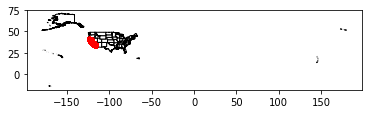

In [39]:
base = states.plot(color='white', edgecolor='black')
points.plot(ax=base, marker='o', color='red', markersize=5);

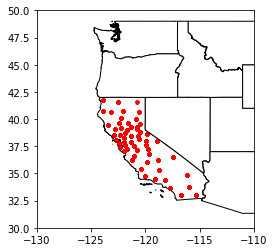

In [53]:
ax = states.plot(color='white', edgecolor='black')
plt.xlim([-130, -110])
plt.ylim([30, 50])
points.plot(ax=ax, marker='o', color='red', markersize=5);



In [69]:
points_unique = points.drop_duplicates()

In [71]:
points_unique.count()

x           58
y           58
geometry    58
dtype: int64

In [178]:
xmin, ymin, xmax, ymax= points_unique.total_bounds
# how many cells across and down
n_cells=30
cell_size = 0.7616#(xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

In [135]:
p = points_unique[points_unique['y'].astype(str).str.contains('41.743135')]

(-124.3238569466887, -114.93876779507178, 32.59869216257996, 42.17858502717501)

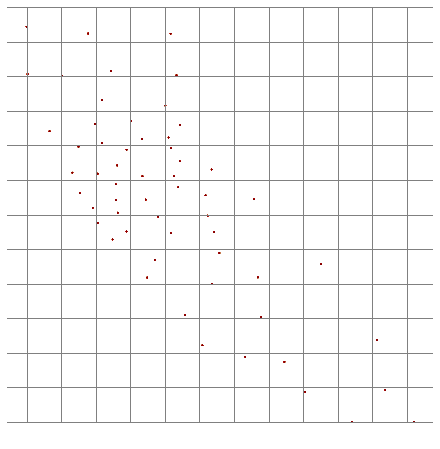

In [185]:
ax = points.plot(markersize=.1, figsize=(12, 8), cmap='jet')
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")


In [42]:
merged = gpd.sjoin(points, cell, how='left', op='within')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/tb/90g6hkm55t9ghflwhwpzcf400000gn/T/ipykernel_33909/637817184.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  merged = gpd.sjoin(points, cell, how='left', op='within')


In [13]:
merged.head()

,x,y,geometry,index_right
0,-117.761091,33.702979,POINT (-117.76109 33.70298),706.0
1,-118.217049,34.358922,POINT (-118.21705 34.35892),644.0
2,-117.761091,33.702979,POINT (-117.76109 33.70298),706.0
3,-118.217049,34.358922,POINT (-118.21705 34.35892),644.0
4,-117.761091,33.702979,POINT (-117.76109 33.70298),706.0


In [46]:
merged['n_fires']=1

In [47]:
merged

,x,y,geometry,index_right,n_fires
0,-117.761091,33.702979,POINT (-117.76109 33.70298),706.0,1
1,-118.217049,34.358922,POINT (-118.21705 34.35892),644.0,1
2,-117.761091,33.702979,POINT (-117.76109 33.70298),706.0,1
3,-118.217049,34.358922,POINT (-118.21705 34.35892),644.0,1
4,-117.761091,33.702979,POINT (-117.76109 33.70298),706.0,1
...,...,...,...,...,...
15221,-118.800497,36.220168,POINT (-118.80050 36.22017),587.0,1
15222,-119.954768,38.027594,POINT (-119.95477 38.02759),465.0,1
15223,-119.078240,34.471595,POINT (-119.07824 34.47160),549.0,1
15224,-121.901583,38.686610,POINT (-121.90158 38.68661),275.0,1


In [43]:
dissolve = merged.dissolve(by="index_right", aggfunc="count")

In [44]:
dissolve.head()

,geometry,x,y
index_right,,,
58.0,POINT (-123.87564 40.69930),289,289
86.0,POINT (-123.39149 39.44023),262,262
122.0,POINT (-123.11265 40.65071),209,209
147.0,POINT (-122.88742 38.52829),283,283
177.0,POINT (-122.72409 38.07387),283,283


In [45]:
cell.loc[dissolve.index, 'n_fires'] = dissolve.n_fires.values

AttributeError: 'GeoDataFrame' object has no attribute 'n_fires'

In [24]:
sum(dissolve.n_fires.values)

14680

(-124.3238569466887, -114.93876779507161, 32.59332704475833, 42.29125250142906)

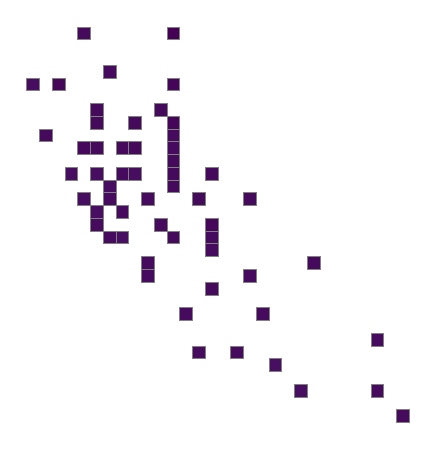

In [179]:
cell1 = cell.reset_index().rename(columns = {'index':'id'})

In [159]:
cell1

,id,geometry
0,0,"POLYGON ((-124.182 33.034, -124.182 33.319, -1..."
1,1,"POLYGON ((-124.182 33.319, -124.182 33.603, -1..."
2,2,"POLYGON ((-124.182 33.603, -124.182 33.887, -1..."
3,3,"POLYGON ((-124.182 33.887, -124.182 34.172, -1..."
4,4,"POLYGON ((-124.182 34.172, -124.182 34.456, -1..."
...,...,...
1019,1019,"POLYGON ((-115.365 40.713, -115.365 40.997, -1..."
1020,1020,"POLYGON ((-115.365 40.997, -115.365 41.282, -1..."
1021,1021,"POLYGON ((-115.365 41.282, -115.365 41.566, -1..."
1022,1022,"POLYGON ((-115.365 41.566, -115.365 41.850, -1..."


In [180]:
pointInPolys = gpd.sjoin(points_unique, cell1, how='inner', op = 'intersects')
pointInPolys = pointInPolys.drop_duplicates(subset=['x', 'y'], keep='first')
count_points = pointInPolys.groupby(['id']).size().reset_index(name='count')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/tb/90g6hkm55t9ghflwhwpzcf400000gn/T/ipykernel_33909/2233267576.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  pointInPolys = gpd.sjoin(points_unique, cell1, how='inner', op = 'intersects')


In [142]:
#pointInPolys1 = gpd.overlay(points_unique, cell, how='intersection')

/var/folders/tb/90g6hkm55t9ghflwhwpzcf400000gn/T/ipykernel_33909/2856645324.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  pointInPolys1 = gpd.overlay(points_unique, cell, how='intersection')


In [125]:
i['count'].sum()

56

In [149]:
points_unique.sort_values(by = 'x').head()

,x,y,geometry
1195,-123.897262,41.743135,POINT (-123.89726 41.74314)
99,-123.875643,40.699303,POINT (-123.87564 40.69930)
558,-123.391486,39.440232,POINT (-123.39149 39.44023)
3258,-123.112653,40.650707,POINT (-123.11265 40.65071)
152,-122.887423,38.528292,POINT (-122.88742 38.52829)


In [148]:
pointInPolys.sort_values(by = 'x').head()

,x,y,geometry,index_right
1195,-123.897262,41.743135,POINT (-123.89726 41.74314),30
1195,-123.897262,41.743135,POINT (-123.89726 41.74314),62
99,-123.875643,40.699303,POINT (-123.87564 40.69930),58
558,-123.391486,39.440232,POINT (-123.39149 39.44023),86
3258,-123.112653,40.650707,POINT (-123.11265 40.65071),122


Remove the duplicate point that is created while merging, because it is counted into 2 different cells

In [151]:
pointInPolys.count()

x              58
y              58
geometry       58
index_right    58
dtype: int64

In [157]:
pointInPolys.head()


,x,y,geometry,index_right
0,-117.761091,33.702979,POINT (-117.76109 33.70298),706
1,-118.217049,34.358922,POINT (-118.21705 34.35892),644
13,-121.695141,37.231795,POINT (-121.69514 37.23179),270
19,-122.440883,37.755130,POINT (-122.44088 37.75513),208
51,-116.735305,33.034142,POINT (-116.73531 33.03414),832


In [161]:
count_points.head()

,id,count
0,30,1
1,58,1
2,62,1
3,86,1
4,122,1


In [162]:
cell1.head()

,id,geometry
0,0,"POLYGON ((-124.182 33.034, -124.182 33.319, -1..."
1,1,"POLYGON ((-124.182 33.319, -124.182 33.603, -1..."
2,2,"POLYGON ((-124.182 33.603, -124.182 33.887, -1..."
3,3,"POLYGON ((-124.182 33.887, -124.182 34.172, -1..."
4,4,"POLYGON ((-124.182 34.172, -124.182 34.456, -1..."


In [305]:
cell_counts = pd.merge(cell1,count_points, on = 'id')

In [184]:
cell_counts.head()

,id,geometry,count
0,11,"POLYGON ((-124.659 41.412, -124.659 42.173, -1...",1
1,21,"POLYGON ((-123.897 39.127, -123.897 39.889, -1...",1
2,23,"POLYGON ((-123.897 40.650, -123.897 41.412, -1...",1
3,32,"POLYGON ((-123.136 37.604, -123.136 38.365, -1...",2
4,33,"POLYGON ((-123.136 38.365, -123.136 39.127, -1...",2


The parameter D and D′ are neighboring datasets; R is the real space; d is the dimension; and ||f(D) − f(D′)||1 is the first-order norm distance [25]. For instance, the global sensitivity of count function is 1.

In [276]:
eps = 1

In [277]:
#cell_counts['dp_count'] = cell_counts['count']+np.random.laplace(0, 1 / eps, 1)[0]


In [320]:
dp_count = []
for row in cell_counts.iterrows():
    dp_count.append(row[1]['count']+np.random.laplace(1, 1 / eps, 1)[0])

In [321]:
cell_counts['count_dp'] = dp_count

In [322]:
noise = np.random.laplace(0,1/0.1,1)

In [323]:
cell_counts['count_dp_rounded'] = round(cell_counts['count_dp'])

In [324]:
cell_counts.head()

,id,geometry,count,count_dp,count_dp_rounded
0,11,"POLYGON ((-124.659 41.412, -124.659 42.173, -1...",1,0.150707,0.0
1,21,"POLYGON ((-123.897 39.127, -123.897 39.889, -1...",1,2.929312,3.0
2,23,"POLYGON ((-123.897 40.650, -123.897 41.412, -1...",1,1.095417,1.0
3,32,"POLYGON ((-123.136 37.604, -123.136 38.365, -1...",2,2.835891,3.0
4,33,"POLYGON ((-123.136 38.365, -123.136 39.127, -1...",2,2.487105,2.0


In [328]:
#cell_counts['geometry']

In [329]:
from shapely import wkt
wkt_string = wkt.dumps(cell_counts['geometry'][0])
print(wkt_string)

POLYGON ((-124.6588619852515620 41.4117418382433868, -124.6588619852515620 42.1733418382433882, -123.8972619852515606 42.1733418382433882, -123.8972619852515606 41.4117418382433868, -124.6588619852515620 41.4117418382433868))


In [332]:
def new_points():
    cursor, conn = db_conn()
    cursor.execute("select st_asText(ST_GeneratePoints(ST_GeomFromText('POLYGON ((-124.6588619852515620 41.4117418382433868, -124.6588619852515620 42.1733418382433882, -123.8972619852515606 42.1733418382433882, -123.8972619852515606 41.4117418382433868, -124.6588619852515620 41.4117418382433868))'),3));")
    
    rows = cursor.fetchall()
    cursor.close()

    result = []
    for index in range(len(rows)):
        result.append([
            rows[index][0]
            
        ])

    return result

In [342]:
def new_points1():
    cursor, conn = db_conn()
    sql = "select st_asText(ST_GeneratePoints(ST_GeomFromText('POLYGON ((-124.6588619852515620 41.4117418382433868, -124.6588619852515620 42.1733418382433882, -123.8972619852515606 42.1733418382433882, -123.8972619852515606 41.4117418382433868, -124.6588619852515620 41.4117418382433868))'),3));"
    
    gdf = gpd.read_postgis(sql, conn, geom_col='geometry', crs=4326)

In [343]:
new_points1()

ValueError: Query missing geometry column 'geometry'

In [337]:
multipoints = new_points()
multipoints

[['MULTIPOINT(-124.28509511140895 41.49030306679869,-124.48416382351053 42.11606281942623,-124.03476331549984 41.985243409816675)']]

In [336]:
multipoints.plot(marker='*', color='red', markersize=12, figsize=(4, 4))

AttributeError: 'list' object has no attribute 'plot'